In [1]:
import numpy as np
import pandas as pd
import copy
from sklearn import datasets
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold
from scipy.stats import mannwhitneyu
from sklearn.metrics import r2_score
from scipy.stats import mannwhitneyu
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
def simul(n_samples = 10, n_features = 5, n_informative = 4, noise = 2):
    X = np.random.binomial(1,.5, n_samples*n_features).reshape(n_samples,n_features)
    coef = np.random.normal(loc =0, scale = 10, size = n_features)
    coef[n_informative:] = 0
    ns = np.random.normal(scale = noise, size = n_samples).reshape(n_samples,1)
    y = np.matmul(X, coef.reshape(n_features,1)) + ns
    return X, y.reshape(n_samples,),coef    

In [3]:
def collin_make(x, max_pos, coef, n_collinear = 1, threshold = 0.1):
    x_new = x.copy()
    coef_new = coef.copy()
    feature_ind = np.where(coef==0)[0]
    col_count = []
    if len(feature_ind) >= n_collinear:

        for i in range(n_collinear):
            inf_feature = np.random.randint(low=0, high = max_pos)
            col_count.append(inf_feature)
            x_new[:, feature_ind[i]] = x_new[:, inf_feature]
            col_count.append(feature_ind[i])

            rn = round(np.random.uniform(low=0, high=threshold)*x.shape[0])
            indx = np.random.randint(0, high = x.shape[0], size = rn)
            x_new[indx, feature_ind[i]] = np.random.binomial(1, 0.5, rn)
            coef_new[feature_ind[i]] = coef_new[inf_feature]
        return x_new, coef_new, col_count
    else:
        print('No empty position to fill')

In [4]:
def test_score_(cross_validate_obj, df, model, corr_method, threshold, filteration, n_collinear_features):
    tmp = pd.DataFrame(cross_validate_obj['test_score'], columns=['test_score'])
    tmp['collinear_features'] = n_collinear_features
    tmp['model'] = model
    tmp['corr_method'] = corr_method
    tmp['threshold'] = threshold
    tmp['filteration'] = filteration
    df = pd.concat([df,tmp], ignore_index=True)
    return df

In [5]:
def cor_coef_calc(cross_validate_obj, df, coef, rep_range,
                  n_collinear_features, model, corr_method, threshold, filteration,
                  n_features=None,tr_col=None, dc = None):
    for j in range(rep_range):
        if j == 0:
            try:
                coef_estimate = cross_validate_obj['estimator'][j].feature_importances_
            except:
                coef_estimate = abs(cross_validate_obj['estimator'][j].coef_)
        else:
            try:
                coef_estimate = coef_estimate + cross_validate_obj['estimator'][j].feature_importances_
            except:
                coef_estimate = coef_estimate + abs(cross_validate_obj['estimator'][j].coef_)
    

    coef_estimate = coef_estimate/(rep_range)
    coef_estimate = coef_estimate/max(coef_estimate)
    coef = abs(coef)/max(abs(coef))
    if dc is None:
        if filteration == 'N':
            cr = np.corrcoef(coef_estimate, coef)[0][1]
        else:
            tmp1 = pd.DataFrame(data = ['P_'+str(i) for i in range(n_features)], columns=['feature'])
            tmp1['coef'] = coef
        
            tmp2 = pd.DataFrame({'feature': tr_col,
                            'estimate': coef_estimate})        
            tmp1 = tmp1.merge(tmp2, how = 'left')
        
            tmp1.fillna(0, inplace = True)
            cr = tmp1.loc[:,'estimate'].corr(tmp1.loc[:,'coef'])
        
    else:
        
        tmp1 = pd.DataFrame(data = ['P_'+str(i) for i in range(n_features)], columns=['feature'])
        tmp1['coef'] = coef
        
        tmp2 = pd.DataFrame({'feature': tr_col,
                            'estimate': coef_estimate})        
        tmp1 = tmp1.merge(tmp2, how = 'left')
        
        for key in dc:
            tmp1.loc[tmp1.loc[:,'feature'].isin(dc[key]), 'estimate'] = tmp1.loc[tmp1['feature']==key, 'estimate'].values[0]
        tmp1.fillna(0, inplace = True)
        
        cr = tmp1.loc[:,'estimate'].corr(tmp1.loc[:,'coef'])
    
    tmp = pd.DataFrame({'correlation': [cr],
                        'collinear_features': n_collinear_features,
                        'model': model,
                        'corr_method': corr_method,
                        'threshold': threshold,
                        'filteration': filteration
                       })
    
    df = pd.concat([df,tmp], ignore_index=True)
    return df

In [6]:
def cross_validate_study(model, train_data, cv, test_scores_df,cor_coef_df,
                          model_name, corr_method, threshold, filteration,rep_range,
                         n_collinear_features,
                         n_features=None,tr_col=None,dc=None):
    
    cv_study = cross_validate(model,train_data,y,cv=cv,return_estimator=True,n_jobs=-1,scoring= 'r2')

    test_scores_df = test_score_(cross_validate_obj=cv_study, 
                                 df= test_scores_df, 
                                 model=model_name, corr_method=corr_method, 
                                 threshold=threshold, filteration=filteration,
                                n_collinear_features=n_collinear_features)

    cor_coef_df = cor_coef_calc(cross_validate_obj=cv_study, df=cor_coef_df,
                                coef = coef, rep_range=rep_range,
                                n_collinear_features=n_collinear_features, 
                                model=model_name, corr_method=corr_method, 
                                threshold=threshold, filteration=filteration,
                                n_features=n_features, tr_col=tr_col, dc=dc
                                )
    
    return test_scores_df, cor_coef_df

In [7]:
# grouping features based on DBSCAN clustering algo
def db_grouped(dat, threshold=0.8, needs_pivot=False):
    from sklearn.cluster import DBSCAN

    if needs_pivot:
        cr_mat = dat.pivot(index='l0', columns='l1', values='cor')
        cr_mat.fillna(1, inplace=True)
    else:
        cr_mat = dat
    cr_mat = (cr_mat - 1) ** 2

    db = DBSCAN(eps=(threshold - 1) ** 2, min_samples=2, metric='precomputed', n_jobs=-1)
    db.fit(cr_mat)

    dc_df = pd.DataFrame(cr_mat.index.tolist(), columns=['feature'])
    dc_df['group'] = db.labels_

    clusters = list(set(db.labels_))
    for cluster in clusters:
        if cluster == -1:
            dc_df.loc[dc_df['group'] == -1, 'group'] = 'No_gr'
        else:
            dc_df.loc[dc_df['group'] == cluster, 'group'] = 'g' + str(cluster)
    try:
        dc_df = dc_df[dc_df['group'] != 'No_gr']
    except:
        dc_df = pd.DataFrame(columns=['feature', 'group'])
    return dc_df

# function for grouping features in saving them in a dictionary file
def group_features(dat):
    dc = {}
    if len(dat) > 0:
        for name, gr in dat.groupby('group'):
            tmp = dat.loc[dat['group'] == name, 'feature'].tolist()
            dc[tmp[0]] = tmp[1:]

        dc_temp = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in dc.items()]))
    return dc

# function for removing the correlated features from the main dataframe
def cor_remove(dat, dic):
    for k in dic.keys():
        dat.drop(dic[k], axis=1, inplace=True)
    return dat


In [8]:
def group_prep(df,y, threshold, non_informative_threshold):
    X_df = pd.DataFrame(df, columns=['P_'+str(i) for i in range(df.shape[1])])
    if non_informative_threshold != 'N':
        pval_list = []
        cols_to_drop = []
        for cl in X_df.columns:
            pval_list.append(mannwhitneyu(y[X_df.loc[:,cl]==1],y[X_df.loc[:,cl]==0])[1])
            if pval_list[-1]>non_informative_threshold:
                cols_to_drop.append(cl)
        if len(cols_to_drop)>0:
            X_df.drop(cols_to_drop, axis=1, inplace=True)
    
    if threshold != 'N':
        cr = X_df.corr(method='spearman')
        dc_df = db_grouped(dat = cr, threshold=threshold, needs_pivot=False)
        dc = group_features(dat = dc_df)
        X_df = cor_remove(X_df, dc)
    else:
        dc = None
    return X_df, dc

In [9]:
%%time
N_samples = [1000]
N_features = [1000,2000]
N_informative = [.01]
folds = 10
reps = 5
counter = 0
cv = RepeatedKFold(n_splits=folds, n_repeats=reps, random_state=0)
sim_data = {}
for n_samples in N_samples:
    for n_features in N_features:
        for Ni in N_informative:
            n_informative = int(Ni*n_features)
            sim_data['data'+str(counter)] = [n_samples, n_features, n_informative]
            cor_coef_df = pd.DataFrame(columns=['collinear_features', 'model', 'corr_method', 'threshold', 'correlation'])
            collinear_features = []
            test_scores_df = pd.DataFrame(columns=['collinear_features', 'model', 'corr_method', 'threshold', 'test_score'])
            cl_to_add = int((n_features-n_informative)*.02)
            print("each step add atleast:", cl_to_add)
            print('counter: ', counter)

            for i in range(5):
                print(i)
                if i == 0:
                    X,y, coef = simul(n_samples = n_samples, n_features = n_features, n_informative = n_informative, noise = 3)
#                     np.savetxt('simul_data/y_data'+str(counter)+'_'+str(i)+".csv", y, delimiter=",")
                else:
                    X, coef, l = collin_make(X, max_pos=n_informative, coef = coef, n_collinear=cl_to_add, threshold=.4)
                    collinear_features.extend(l)
                
#                 np.savetxt('simul_data/X_data'+str(counter)+'_'+str(i)+".csv", X, delimiter=",")
#                 np.savetxt('simul_data/coef_data'+str(counter)+'_'+str(i)+".csv", coef, delimiter=",")
                
                for tr in ['N',0.7,.9]:
                    for fl in ['N',0.2]:
                        X_df, dc = group_prep(df=X, y=y, threshold=tr, non_informative_threshold=fl)
                        rf = RandomForestRegressor(max_depth=5, n_estimators=500, n_jobs=-1, random_state=123)
                        test_scores_df, cor_coef_df = cross_validate_study(model=rf, train_data=X_df, cv=cv, 
                                             test_scores_df=test_scores_df,cor_coef_df=cor_coef_df,
                                             model_name='rf', corr_method='sp', threshold=str(tr), filteration=str(fl),
                                                                           rep_range=folds*reps,
                                             n_collinear_features=len(set(collinear_features)),
                                             n_features=n_features,tr_col=X_df.columns,dc=dc)

                        dt = DecisionTreeRegressor(max_depth=5, random_state=123)
                        test_scores_df, cor_coef_df = cross_validate_study(model=dt, train_data=X_df, cv=cv, 
                                             test_scores_df=test_scores_df,cor_coef_df=cor_coef_df,
                                             model_name='dt', corr_method='sp', threshold=str(tr), filteration=str(fl),
                                                                           rep_range=folds*reps,
                                             n_collinear_features=len(set(collinear_features)),
                                             n_features=n_features,tr_col=X_df.columns,dc=dc)

                        ada = AdaBoostRegressor(random_state=123)
                        test_scores_df, cor_coef_df = cross_validate_study(model=ada, train_data=X_df, cv=cv, 
                                             test_scores_df=test_scores_df,cor_coef_df=cor_coef_df,
                                             model_name='ada', corr_method='sp', threshold=str(tr),filteration=str(fl),
                                                                           rep_range=folds*reps,
                                             n_collinear_features=len(set(collinear_features)),
                                             n_features=n_features,tr_col=X_df.columns,dc=dc)

            test_scores_df.loc[:,'samples'] = n_samples
            test_scores_df.loc[:,'n_features'] = n_features
            test_scores_df.loc[:,'n_informative'] = n_informative
            test_scores_df.loc[:,'label'] = 'data'+str(counter)
            cor_coef_df.loc[:,'samples'] = n_samples
            cor_coef_df.loc[:,'n_features'] = n_features
            cor_coef_df.loc[:,'n_informative'] = n_informative
            cor_coef_df.loc[:,'label'] = 'data'+str(counter)
            if counter == 0:
                fi_test_scores_df = test_scores_df.copy()
                fi_cor_coef_df = cor_coef_df.copy()
            else:
                fi_test_scores_df = pd.concat([fi_test_scores_df,test_scores_df], ignore_index=True)
                fi_cor_coef_df = pd.concat([fi_cor_coef_df,cor_coef_df], ignore_index=True)
            counter+=1

sim_data = pd.DataFrame.from_dict(sim_data, orient='index', columns=['n_samples', 'n_features', 'n_informative'])
sim_data.to_csv('simul_data/sim_data.csv')
fi_test_scores_df.to_csv('results/fi_test_scores_df.csv', index=False)
fi_cor_coef_df.to_csv('results/fi_cor_coef_df.csv', index=False)

each step add atleast: 19
counter:  0
0


/Users/CrandallLab/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


1


/Users/CrandallLab/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


2


/Users/CrandallLab/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/CrandallLab/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


3


/Users/CrandallLab/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/CrandallLab/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/CrandallLab/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


4


/Users/CrandallLab/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


each step add atleast: 39
counter:  1
0


/Users/CrandallLab/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/CrandallLab/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/CrandallLab/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/CrandallLab/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be

1


/Users/CrandallLab/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/CrandallLab/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/CrandallLab/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


2
3


/Users/CrandallLab/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


4


/Users/CrandallLab/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/CrandallLab/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/CrandallLab/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CPU times: user 16min 12s, sys: 2min 27s, total: 18min 39s
Wall time: 1h 27min 57s


In [12]:
fi_cor_coef_df.loc[:,'method'] = fi_cor_coef_df.loc[:,'threshold'] + "_" + fi_cor_coef_df.loc[:,'filteration']

In [10]:
sim_data

,n_samples,n_features,n_informative
data0,1000,1000,10
data1,1000,2000,20


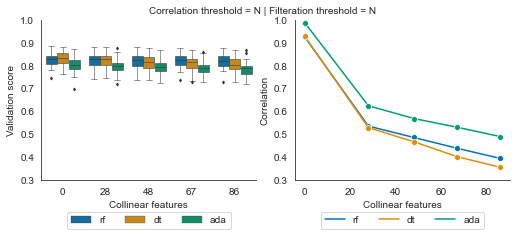

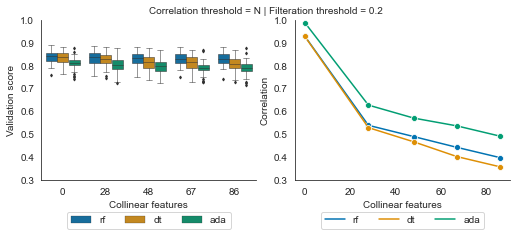

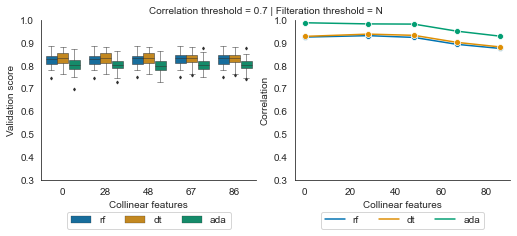

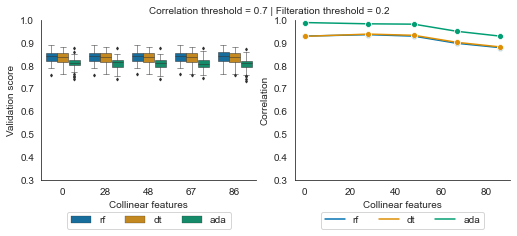

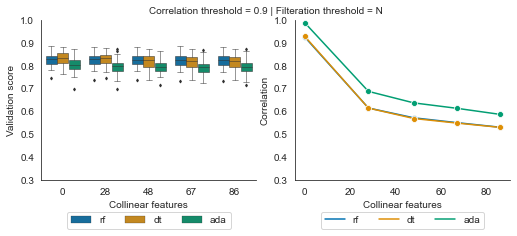

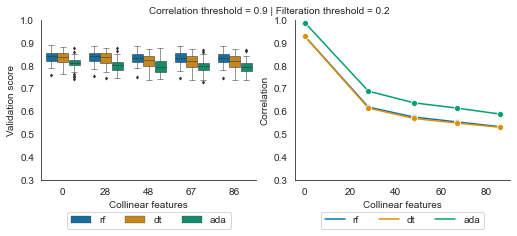

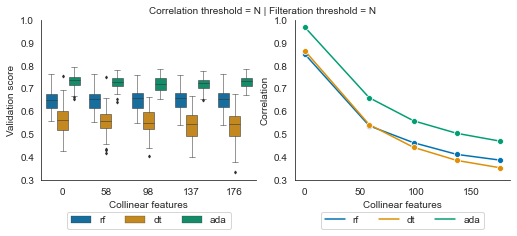

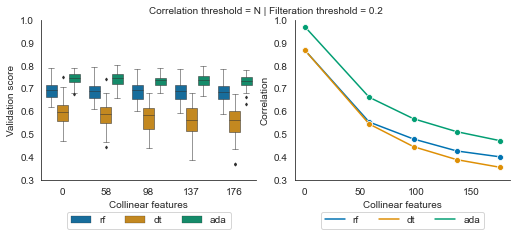

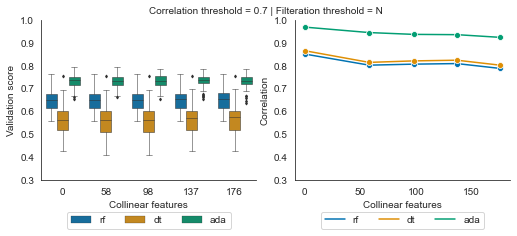

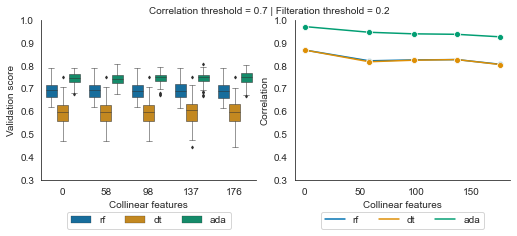

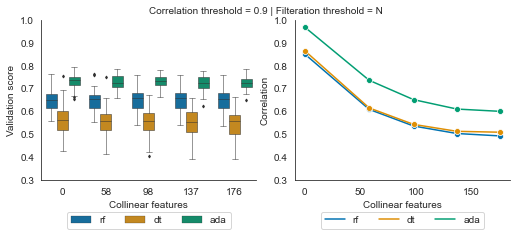

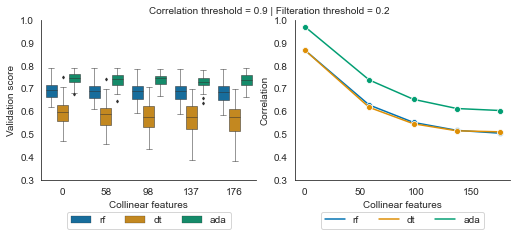

In [25]:
for dat in ['data0', 'data1']:
    for thr in ['N',0.7,.9]:
        for fil in ['N', 0.2]:
        
            fig, axes = plt.subplots(1, 2, figsize=(7.2, 2.8))
            sns.set_style("white")
            # sns.set_context("paper")
            fig.tight_layout(h_pad=4)
            # fig.suptitle('Simulation Study | '+ 'data_label', fontsize = 5, fontweight = 'bold')
            tmp1 = fi_cor_coef_df[(fi_cor_coef_df.loc[:,'label'] == dat) &
                                 (fi_cor_coef_df.loc[:,'threshold'] ==str(thr)) &
                                 (fi_cor_coef_df.loc[:,'filteration'] == str(fil))]
            tmp2 = fi_test_scores_df[(fi_test_scores_df.loc[:,'label'] == dat) &
                                 (fi_test_scores_df.loc[:,'threshold'] == str(thr)) &
                                 (fi_test_scores_df.loc[:,'filteration'] == str(fil))]
            # sns.set_style("whitegrid")
            g = sns.boxplot(ax=axes[0],x='collinear_features', y = 'test_score',
                        hue='model', data=tmp2, palette='colorblind',linewidth=.5, fliersize=2)
            sns.despine()
            axes[0].get_legend().remove()
            axes[0].set_ylabel('Validation score')
            axes[0].set_xlabel('Collinear features')
            axes[0].set_ylim((.3,1))
            sns.lineplot(ax=axes[1], x = 'collinear_features', y = 'correlation',
                         hue='model', data=tmp1, marker='o', palette='colorblind')
            sns.despine()
            axes[1].set_ylabel('Correlation')
            axes[1].set_xlabel('Collinear features')
            axes[1].set_ylim((.3,1))
            left_title = 'Correlation threshold = ' + str(thr) + ' | Filteration threshold = ' + str(fil)
            axes[0].set_title(left_title,ha='left', x = 0.5, fontsize = 10)
            leg1 = axes[0].legend(loc='center', bbox_to_anchor=(0.5, -0.25), shadow=False, ncol=3)
            leg2 = axes[1].legend(loc='center', bbox_to_anchor=(0.5, -0.25), shadow=False, ncol=3)
            plt.savefig(str('img/sim_' + str(350) +dat+'_'+str(thr)+'_'+str(fil)+ '.png'), bbox_inches='tight', dpi = 600)

In [113]:
fi_cor_coef_df.loc[:,'correlation'].min()

0.39910827506174196

In [12]:
def sim_plot(test_scores, core_scores, data_label):
    thr_list = list(set(fi_cor_coef_df.loc[:,'threshold']))
    filter_list = list(set(fi_cor_coef_df.loc[:,'filteration']))
    row_num = len(thr_list)*len(filter_list)
    line_min = fi_cor_coef_df.loc[(fi_cor_coef_df.loc[:,'label'] == data_label),'correlation'].min()*.9
    box_min = max(fi_test_scores_df.loc[(fi_test_scores_df.loc[:,'label'] == data_label),'test_score'].min()*.9,0)
    fig, axes = plt.subplots(row_num, 2, figsize=(7.2, 3*row_num))
    sns.set_style("whitegrid")
    
    fig.tight_layout(h_pad=4)
    

    cn_i = 0
    cn_j = 0
    for thr in thr_list:
        for fil in filter_list:
            tmp1 = fi_cor_coef_df[(fi_cor_coef_df.loc[:,'label'] == data_label) &
                     (fi_cor_coef_df.loc[:,'threshold'] == thr) &
                     (fi_cor_coef_df.loc[:,'filteration'] == fil)]
            tmp2 = fi_test_scores_df[(fi_test_scores_df.loc[:,'label'] == data_label) &
                     (fi_test_scores_df.loc[:,'threshold'] == thr) &
                     (fi_test_scores_df.loc[:,'filteration'] == fil)]
            
            sns.boxplot(ax=axes[cn_i, 0],x='collinear_features', y = 'test_score',
            hue='model', data=tmp2, palette='colorblind')
            sns.despine(left=True)
            sns.lineplot(ax=axes[cn_i, 1], x = 'collinear_features', y = 'correlation',
             hue='model', data=tmp1, marker='o', palette='colorblind')
            sns.despine()
            title = 'Correlation threshold = ' + thr + ' | Filteration threshold = ' + fil
            axes[cn_i, 0].set_title(title,ha='left', x = .5, fontsize = 12, fontweight = 'bold')
            axes[cn_i, 0].get_legend().remove()
            axes[cn_i, 1].get_legend().remove()
            
            axes[cn_i, 0].set_ylim(box_min, 1)
            axes[cn_i, 1].set_ylim(line_min, 1)
            
            cn_i += 1
            if cn_i == row_num:
                leg1 = axes[-1, 0].legend(loc='center', bbox_to_anchor=(0.5, -0.25), shadow=False, ncol=3)
                leg2 = axes[-1, 1].legend(loc='center', bbox_to_anchor=(0.5, -0.25), shadow=False, ncol=3)
    fig.suptitle('Simulation Study | '+ data_label, fontsize = 14, fontweight = 'bold')
    plt.subplots_adjust(top=.93)
    plt.savefig(str(data_label+'_1sim_' + str(600) + '.png'), bbox_inches='tight', dpi = 600)

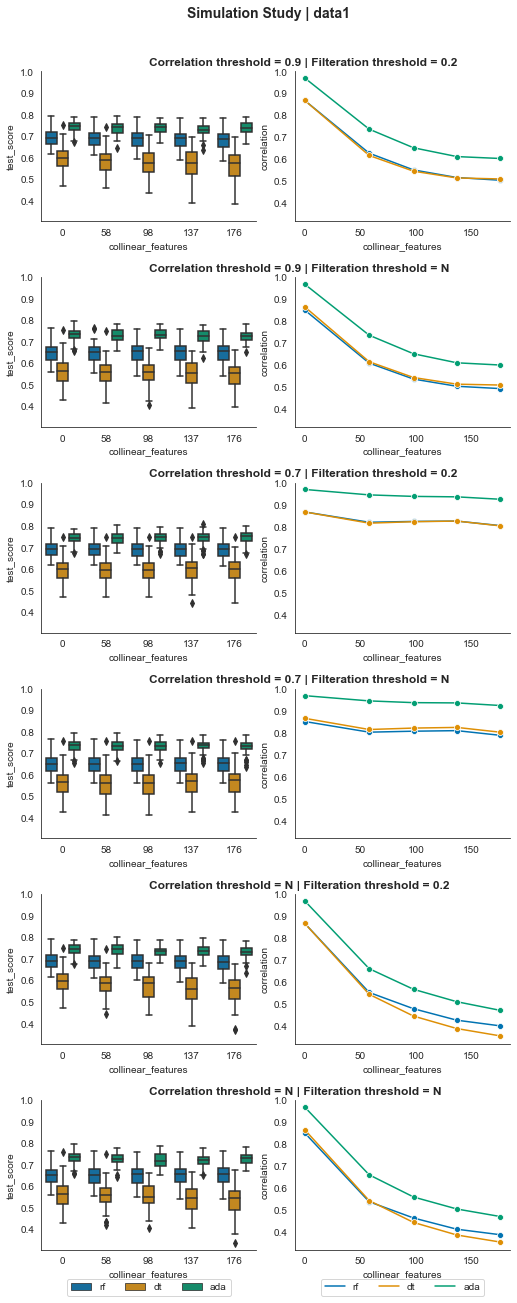

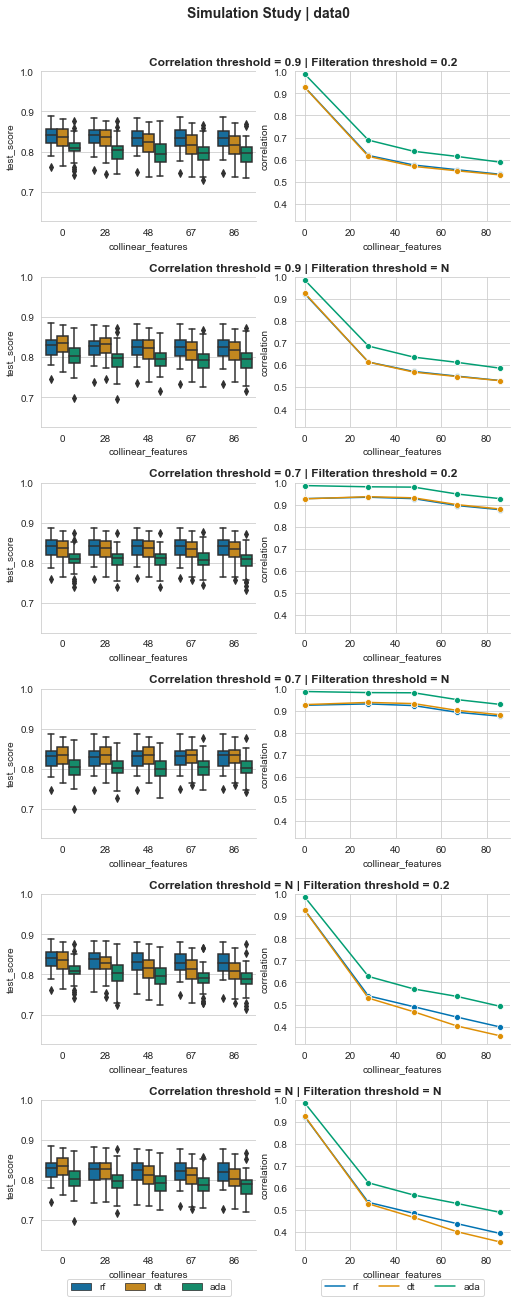

In [13]:
for data_label in list(set(fi_cor_coef_df['label'])):
    sim_plot(test_scores=fi_test_scores_df, core_scores=fi_cor_coef_df,data_label=data_label)